In [2]:
import sys
import os
root_dir = os.getcwd().replace('/notebooks','')
sys.path.insert(1, root_dir)
import pandas as pd
from datetime import datetime as dt
import glob
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar
import os
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
from zipline.data.bundles import register, unregister
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar
# from exchange_calendars.exchange_calendar_xdse import XDSExchangeCalendar
from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, 
                     INFO, WARNING, DEBUG, ERROR)
from zipline.api import (order, 
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         order_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, symbol
from pyfolio.tears import create_full_tear_sheet
from pyfolio.utils import extract_rets_pos_txn_from_zipline
import seaborn as sns
import quantstats as qs
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

## Preferred Stocks to Backtest

In [10]:
prefs = ["AAPL"]

## Bollinger Bands on Single Asset

## Backtest

In [62]:
def initialize(context):
    context.i = 0
    context.asset = symbol("AMGN")
    context.window = 90
    context.buy_signal = False
    context.sell_signal = False
    context.buy_counter = 0

def handle_data(context, data):
    context.i += 1
    # skipping first 90 trading days
    if context.i <= context.window:
        return
    
    buy_signal = False
    sell_signal = False

    prices = data.history(context.asset, 'price', bar_count=30, frequency='1d')
    current_date = data.history(context.asset, 'price', bar_count=2, frequency='1d').index[-1]

    sma = prices.mean()
    rolling_std = prices.std()

    upper_band = sma + 2 * rolling_std
    lower_band = sma - 2 * rolling_std

    cost_basis = context.portfolio.positions[context.asset].cost_basis
    amount = context.portfolio.positions[context.asset].amount
    cash = context.portfolio.cash
    curr_price = data.current(context.asset, "price")

    if curr_price >= upper_band and context.buy_counter != 0:
        order_target_percent(context.asset, 0.0, stop_price=(curr_price*0.90))
        sell_signal = True
        context.buy_counter = 0
        print(f"date:{current_date} - sell: {sell_signal} - cash: {cash} - price:{curr_price} - ub:{upper_band} - lb:{lower_band}")
    elif curr_price <= lower_band and context.buy_counter < 4:
        order_value(context.asset, (cash * 0.20))
        buy_signal = True
        context.buy_counter += 1
        print(f"date:{current_date} - buy: {buy_signal} - buy_count:{context.buy_counter} - cash: {cash} - price:{curr_price} - ub:{upper_band} - lb:{lower_band}")
    else:
        pass
    
    record(Asset_price=data.current(context.asset, 'price'),
                UPPER_BAND=upper_band,
                LOWER_BAND=lower_band,
                BUY_Signal=buy_signal,
                SELL_Signal=sell_signal,
                Cost_Basis=cost_basis,
                Stocks=amount)
    
    


In [63]:
start_date = "2010-01-01"
end_date = "2024-01-01"
capital_base = 10000
calendar = get_calendar('NYSE')
bundle_data = bundles.load("sp500")

result = run_algorithm(start=pd.Timestamp(start_date),
                        end=pd.Timestamp(end_date),
                        initialize=initialize,
                        handle_data=handle_data,
                        capital_base=capital_base,
                        trading_calendar=calendar,
                        bundle='sp500',
                        data_frequency='daily',
                        )

date:2010-05-26 00:00:00 - buy: True - buy_count:1 - cash: 10000.0 - price:50.36 - ub:61.88009166675719 - lb:51.00724166657614
date:2010-08-24 00:00:00 - buy: True - buy_count:2 - cash: 7993.188115 - price:51.06 - ub:56.35525676232137 - lb:51.26807657101198
date:2010-10-18 00:00:00 - sell: True - cash: 6385.313595 - price:57.96 - ub:57.56954677461087 - lb:53.21645322538913
date:2011-01-31 00:00:00 - buy: True - buy_count:1 - cash: 6385.313595 - price:55.08 - ub:57.97896805113775 - lb:55.08836528219559
date:2011-02-11 00:00:00 - buy: True - buy_count:2 - cash: 5103.31993 - price:53.74 - ub:58.02099779895138 - lb:54.00166886771532
date:2011-02-16 00:00:00 - buy: True - buy_count:3 - cash: 4133.337189999999 - price:52.95 - ub:58.27248910199189 - lb:53.31351089800811
date:2011-02-17 00:00:00 - buy: True - buy_count:4 - cash: 3346.7791149999994 - price:52.410000000000004 - ub:58.39117809225717 - lb:52.90682190774283
date:2011-04-13 00:00:00 - sell: True - cash: 6349.287875 - price:54.94 - u

### Quantstats Tearsheet

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2010-05-27   2010-05-27
End Period                 2023-12-29   2023-12-29
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       98.0%

Cumulative Return          346.63%      99.85%
CAGR﹪                     7.89%        3.58%

Sharpe                     0.72         0.38
Prob. Sharpe Ratio         99.55%       91.74%
Smart Sharpe               0.65         0.34
Sortino                    1.01         0.55
Smart Sortino              0.91         0.5
Sortino/√2                 0.71         0.39
Smart Sortino/√2           0.64         0.35
Omega                      1.08         1.08

Max Drawdown               -33.92%      -31.18%
Longest DD Days            725          1794
Volatility (ann.)          17.49%       17.75%
R^2                        0.24         0.24
Information Ratio          -0.02        -0.02
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-08-03,2016-11-03,2020-06-30,1794,-31.182165,-30.047057
2,2021-04-21,2023-06-01,2023-12-29,983,-28.344502,-28.156744
3,2013-04-23,2013-06-05,2013-08-23,123,-15.525188,-14.512565
4,2020-07-21,2020-10-28,2021-04-19,273,-14.994273,-14.496301
5,2014-03-19,2014-05-15,2014-07-29,133,-13.095700,-12.722191


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


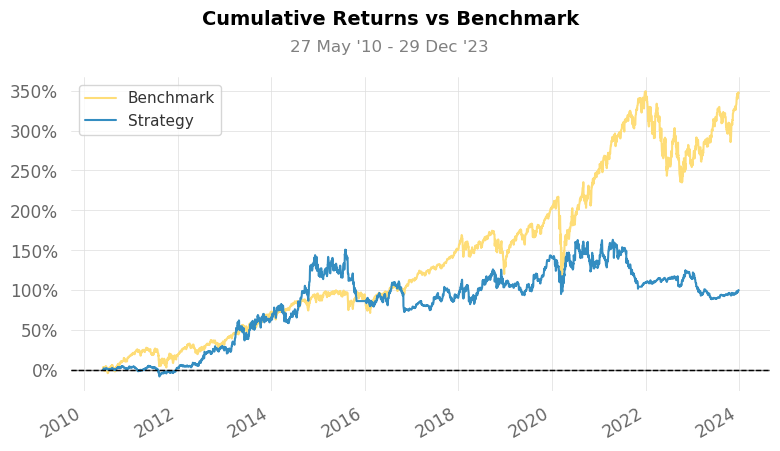

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


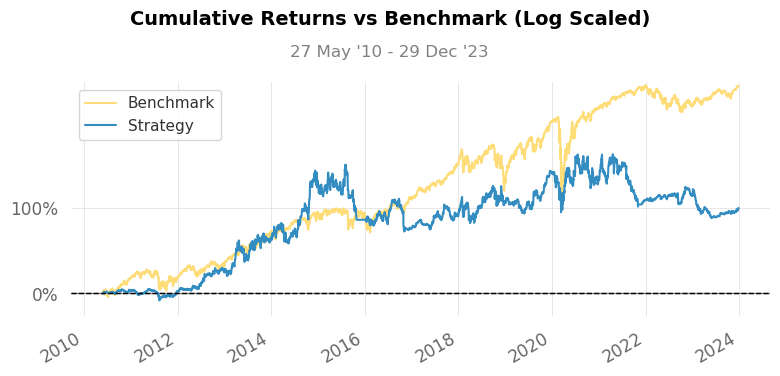

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


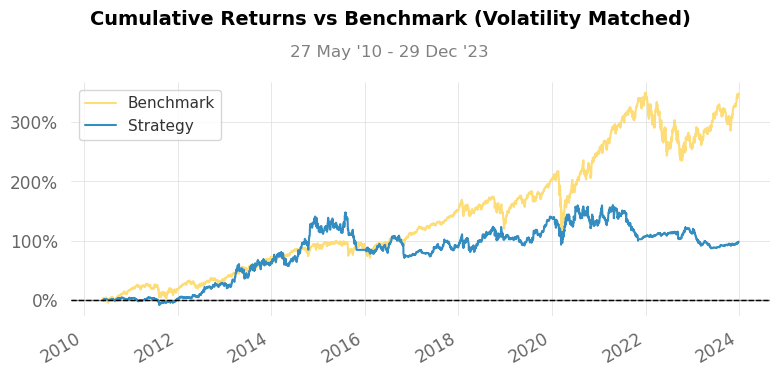

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


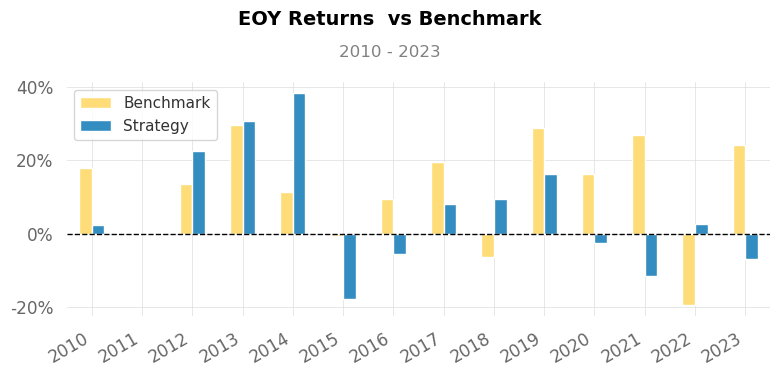

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


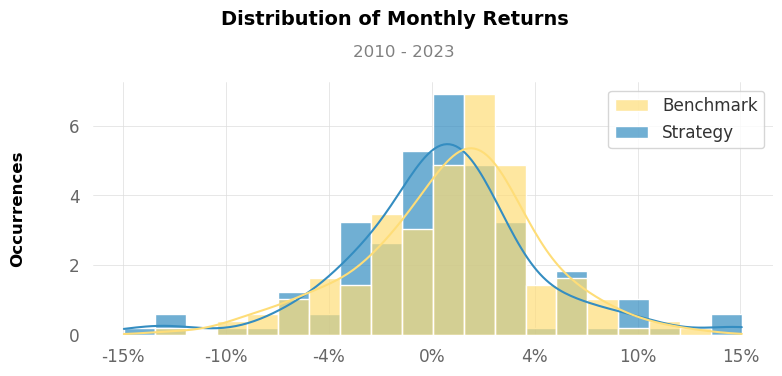

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


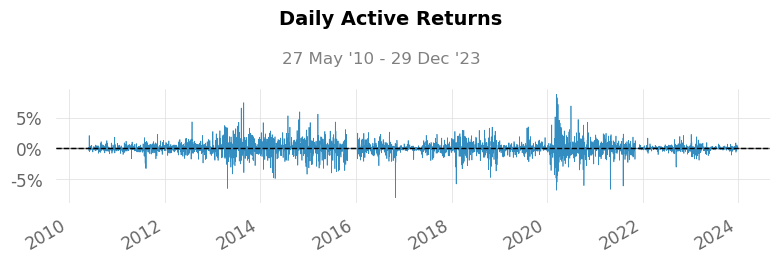

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


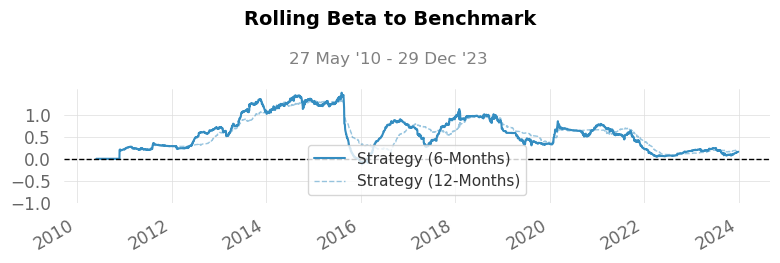

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


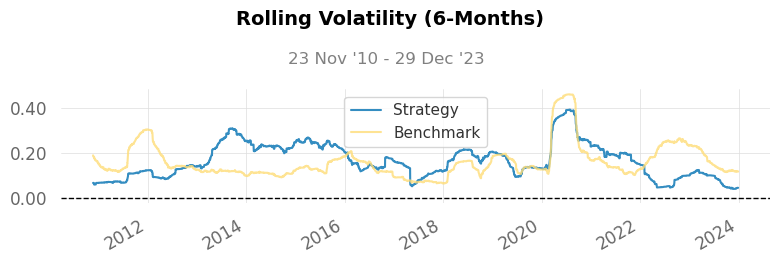

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


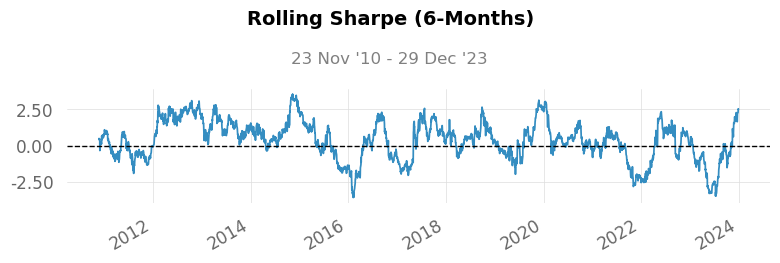

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


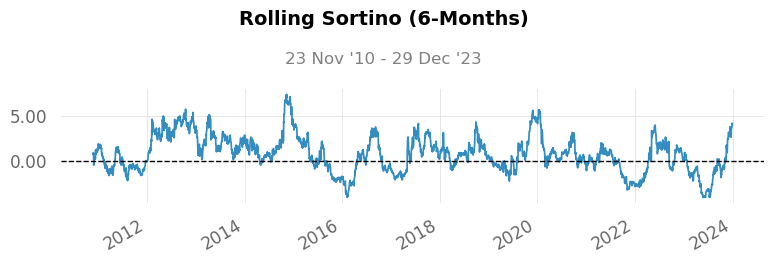

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


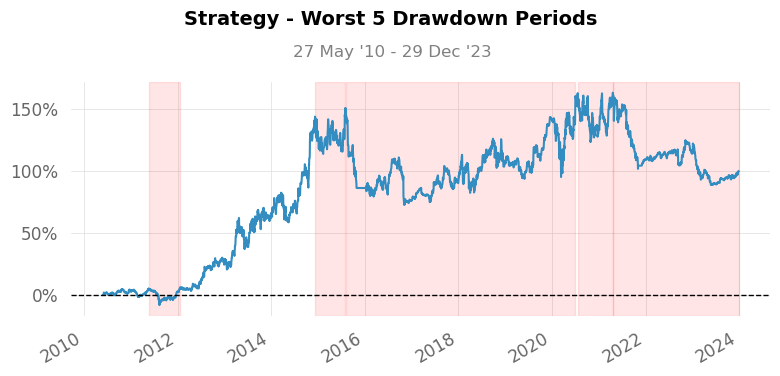

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


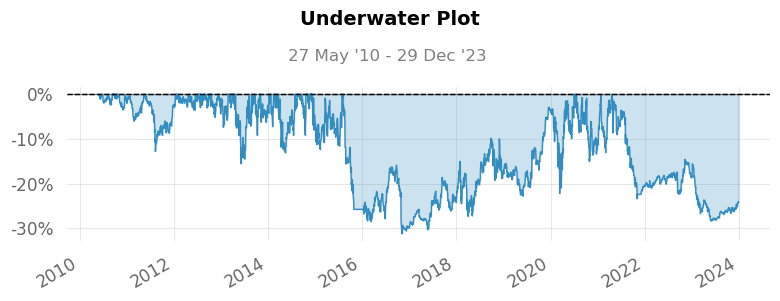

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


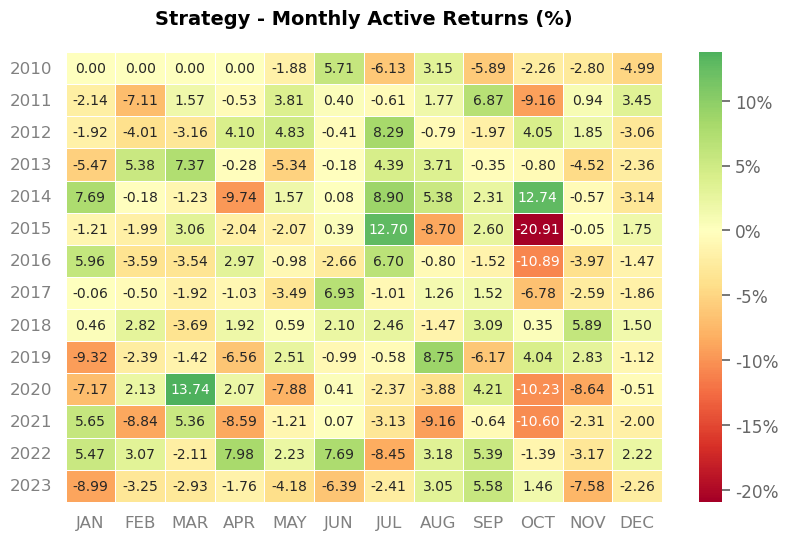

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


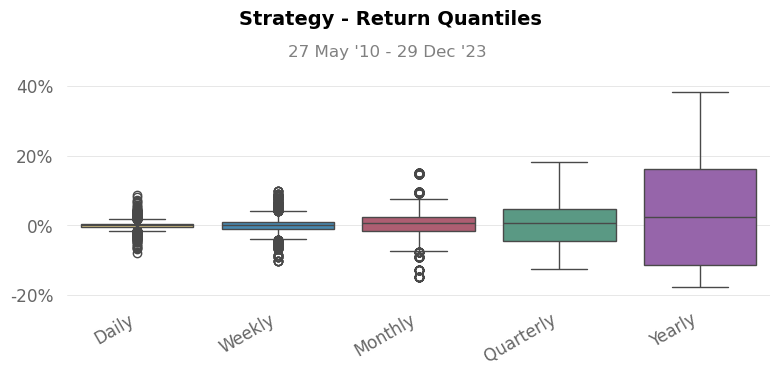

In [64]:
start = result.index[0]
end = result.index[-1]
benchmark = yf.download('^GSPC', start=start, end=end)['Adj Close'].pct_change()
result.index = pd.to_datetime(result.index).tz_convert(None)
result.index = benchmark.index    
qs.reports.full(result['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = result)

In [31]:
# filtered_result = result.query('BUY_Signal == True or SELL_Signal == True')
columns = ["trading_days","UPPER_BAND", "LOWER_BAND","Asset_price","Cost_Basis","Stocks","BUY_Signal","SELL_Signal","starting_cash","ending_cash"]
result[columns].to_csv(f"output.csv")

# Running Backtest with multiple asset

In [3]:
tickers = ['BDX','NI','ED','GEN','D','K','AMGN','CL','GILD','BIIB','EVRG','ATO','SJM','IFF','INCY','PNW','DLR','EIX','CAH','KMB','VZ','BAX','CME','CPB','AEP','CNC']

In [8]:
start = '2019-01-01'
end = '2020-01-01'
capital_base = 10000
calendar = get_calendar('NYSE')
symb = "CTAS"
bundle_data = bundles.load("sp500")
window = 20

def initialize(context):
    context.i = 0
    context.buy_counter = {}
    sids = bundle_data.asset_finder.sids
    context.assets = bundle_data.asset_finder.retrieve_all(sids)


def handle_data(context, data):
    # Skip first 90 days to get full windows
    context.i += 1
    if context.i < window+1:
        return

    for asset in context.assets:
        if asset.symbol in tickers:
            buy_signal = False
            sell_signal = False
            prices = data.history(asset, 'price', bar_count=20, frequency='1d')
            current_date = data.history(asset, 'price', bar_count=2, frequency='1d').index[-1]

            sma = prices.mean()
            rolling_std = prices.std()

            upper_band = sma + 2 * rolling_std
            lower_band = sma - 2 * rolling_std
            
            cost_basis = context.portfolio.positions[asset].cost_basis
            amount = context.portfolio.positions[asset].amount
            cash = context.portfolio.cash
            price = data.current(asset, "price")

            buy_count = context.buy_counter.get(asset.symbol, 0)

            if price > upper_band and asset.symbol in context.buy_counter:
                order_target_percent(asset, 0)    
                sell_signal = True
                del context.buy_counter[asset.symbol]
                print(f"current_date:{current_date} - sell_signal: {sell_signal}- asset:{asset.symbol} - cash: {cash} - price:{price} - upper_band:{upper_band} - lower_band:{lower_band}")
    
            elif price <= lower_band and buy_count < 4:
                order_value(asset, cash * 0.1)
                context.buy_counter[asset.symbol] = buy_count + 1
                print(f"current_date:{current_date} - buy_signal: {buy_signal} - asset:{asset.symbol} - cash: {cash} - price:{price} - upper_band:{upper_band} - lower_band:{lower_band}")
            else:
                pass

            record(Asset_price=data.current(asset, 'price'),
                UPPER_BAND=upper_band,
                LOWER_BAND=lower_band,
                BUY_Signal=buy_signal,
                SELL_Signal=sell_signal,
                Cost_Basis=cost_basis,
                Stocks=amount)

    


    
    

result = run_algorithm(start=pd.Timestamp(start),
                        end=pd.Timestamp(end),
                        initialize=initialize,
                        handle_data=handle_data,
                        capital_base=capital_base,
                        trading_calendar=calendar,
                        bundle='sp500',
                        data_frequency='daily',
                        )


current_date:2019-02-07 00:00:00 - buy_signal: False - asset:BIIB - cash: 10000.0 - price:308.73 - upper_band:345.7394114388018 - lower_band:319.8645885611981
current_date:2019-02-07 00:00:00 - buy_signal: False - asset:K - cash: 10000.0 - price:52.432 - upper_band:56.53451800628439 - lower_band:53.396881993715624
current_date:2019-02-08 00:00:00 - buy_signal: False - asset:BIIB - cash: 8066.012500500001 - price:315.12 - upper_band:347.16203836640614 - lower_band:316.8349616335937
current_date:2019-02-08 00:00:00 - buy_signal: False - asset:K - cash: 8066.012500500001 - price:51.981 - upper_band:56.88860833174128 - lower_band:52.767691668258706
current_date:2019-02-11 00:00:00 - buy_signal: False - asset:K - cash: 6647.4665905 - price:52.272 - upper_band:57.044336272738875 - lower_band:52.33866372726112
current_date:2019-02-12 00:00:00 - buy_signal: False - asset:GILD - cash: 6010.1761105000005 - price:65.4 - upper_band:70.79393309922064 - lower_band:66.12506690077937
current_date:2019

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-02-08   2019-02-08
End Period                 2019-12-31   2019-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          19.39%       8.67%
CAGR﹪                     14.68%       6.64%

Sharpe                     1.73         0.99
Prob. Sharpe Ratio         94.03%       82.06%
Smart Sharpe               1.61         0.91
Sortino                    2.42         1.38
Smart Sortino              2.24         1.28
Sortino/√2                 1.71         0.98
Smart Sortino/√2           1.58         0.91
Omega                      1.19         1.19

Max Drawdown               -6.84%       -7.82%
Longest DD Days            89           120
Volatility (ann.)          11.81%       9.9%
R^2                        0.28         0.28
Information Ratio          -0.06        -0.06
Calmar                 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-02-21,2019-04-22,2019-06-20,120,-7.820432,-7.696423
2,2019-06-24,2019-08-05,2019-08-16,54,-2.372543,-1.790638
3,2019-10-01,2019-10-02,2019-10-16,16,-1.789879,-1.591753
4,2019-10-25,2019-11-11,2019-11-19,26,-1.669388,-1.369431
5,2019-08-20,2019-08-23,2019-08-30,11,-1.412430,-0.877879


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


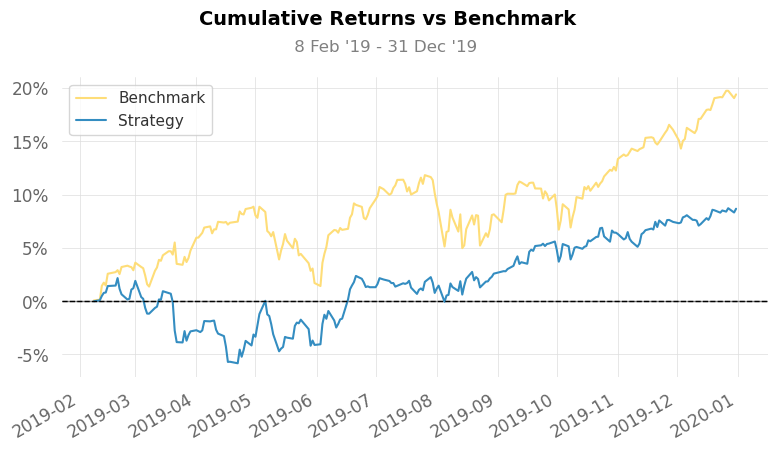

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


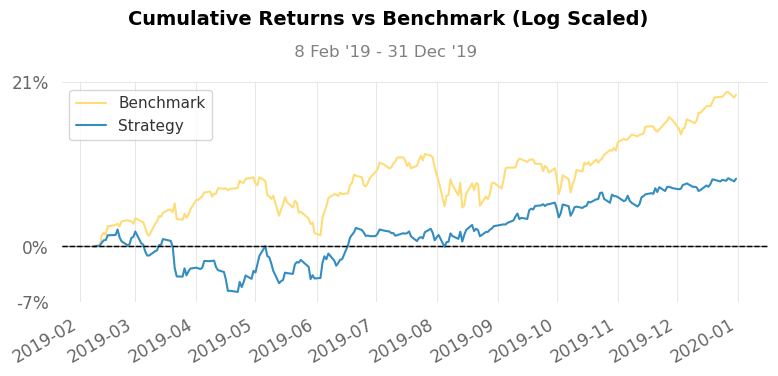

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


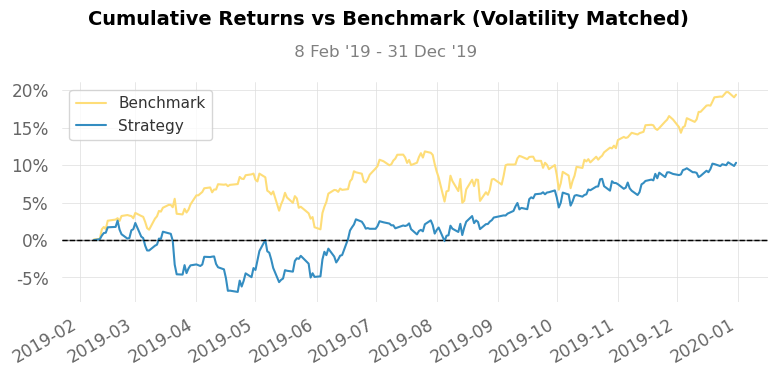

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


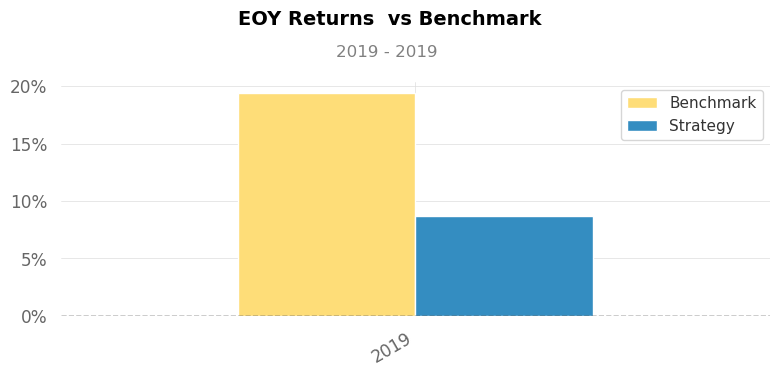

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


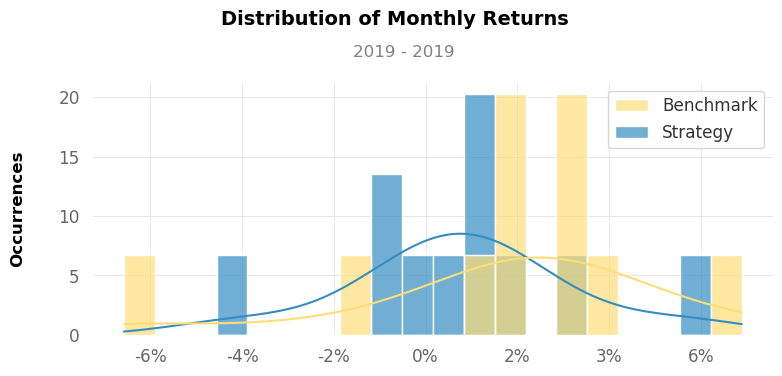

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


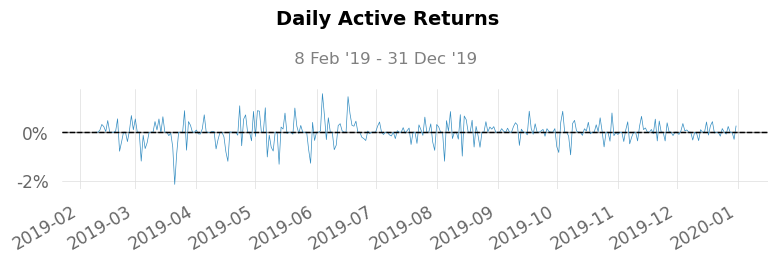

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


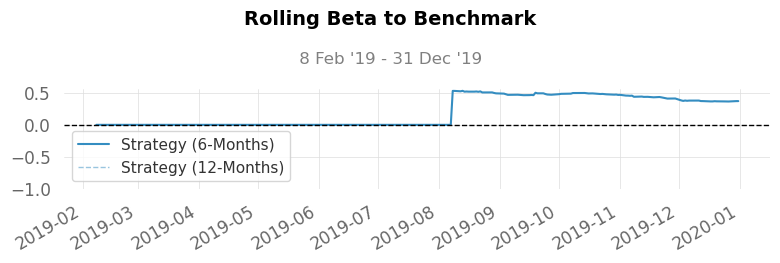

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


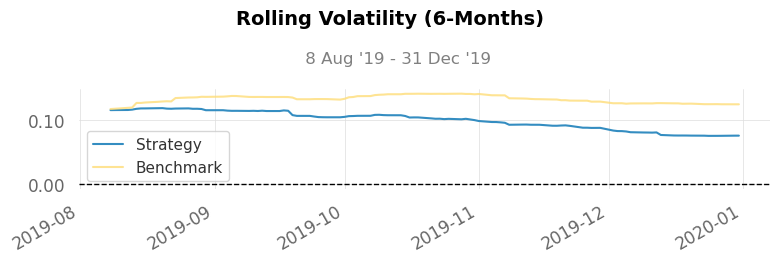

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


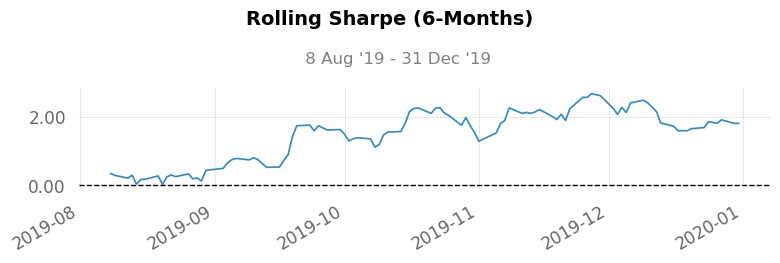

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


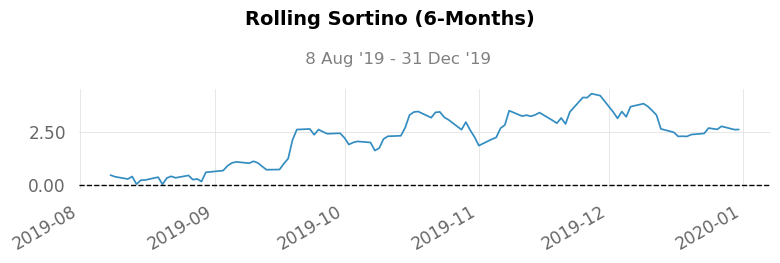

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


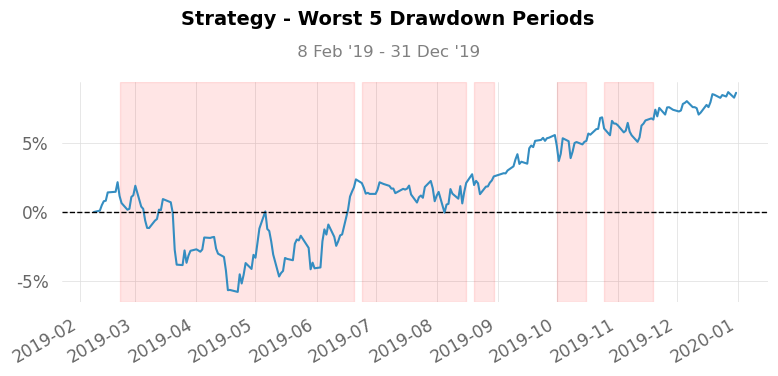

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


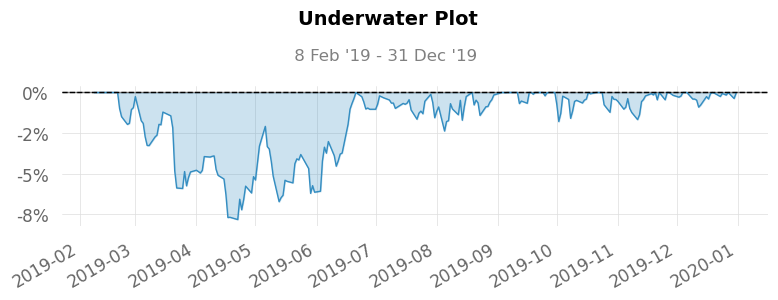

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


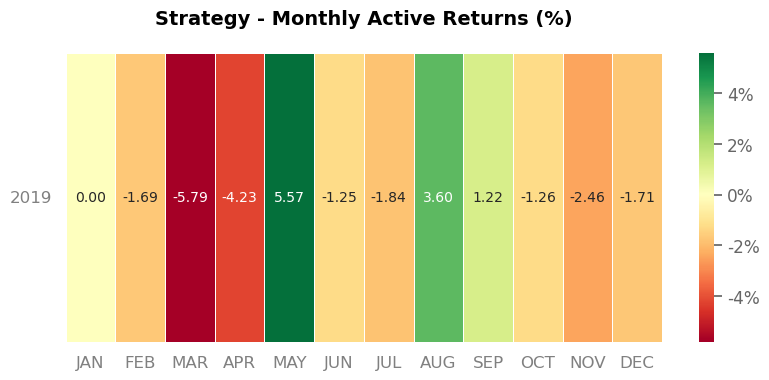

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


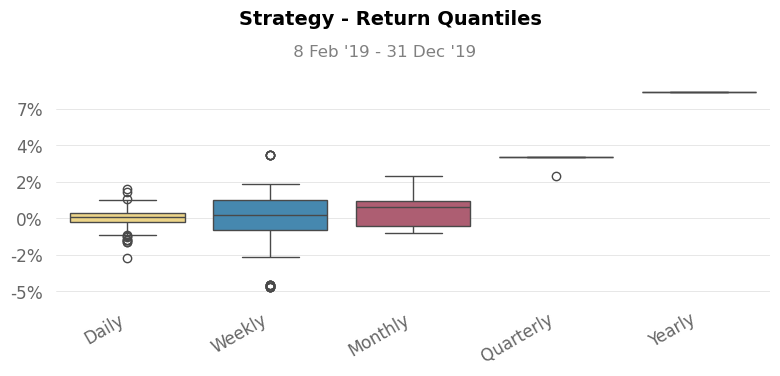

In [9]:
start = result.index[0]
end = result.index[-1]
benchmark = yf.download('^GSPC', start=start, end=end)['Adj Close'].pct_change()
result.index = pd.to_datetime(result.index).tz_convert(None)
result.index = benchmark.index    
qs.reports.full(result['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = result)